<a id='top'></a> 
# CHILD ML Analysis
    - ML Pipeline for CHILD Dataset from the very beginning

##### [Step One: Feature Selection Strategies (Insights)](#0)

##### [Step Two: Making ML Pipelines](#pipeline)

##### Step Three: Tunning & Feature Engineering/Selection (data review) to Improve Performance (Insights)

##### Step Four: Visualization of model performance

##### Step Five: Paper, Deployment

### Libraries

In [356]:
# Preferences of autoformatting & Multiple Output
%load_ext nb_black

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import warnings

warnings.filterwarnings("ignore")

import researchpy as rp  # For auto-statistics/EDA of dataframe
from tqdm.notebook import tqdm  # For process display

import sys

sys.path.append("../src")

from data import *
from utils import *
from conf import *
from tools import *

import utils as UT

import random

import matplotlib.pyplot as plt
import seaborn as sns


# ML Libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_curve,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.inspection import permutation_importance
from collections import defaultdict

from six import StringIO
from IPython.display import Image
import pydotplus

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

### Data

In [2]:
# df_raw = generate_raw_xlsx()
df_child = load_child_with_more()

The path for all the CHILD data is located at ../data/
Generating a merged DataFrame For Analyzing and Modelling...
The DataFrame for ML is saved to ../output 


<IPython.core.display.Javascript object>

### Define target

In [5]:
df_targeted = target_selector(
    df_child, target_name="Asthma_Diagnosis_5yCLA", target_mapping={2: np.nan}
)

The dimension of original dataframe for process is (3455, 172)
Number of categorical features is:  71
Number of numeric features is:  24
Number of target variables is:  13
Number of dropped features is:  63
The difference of features of targeted and original dataframe is :{'Subject_Number'}
The number of missing value for target label is: 809
------------------------------------------------------
Note: Target variable can be one of: 
 ['Asthma_Diagnosis_3yCLA', 'Asthma_Diagnosis_5yCLA', 'Recurrent_Wheeze_1y', 'Recurrent_Wheeze_3y', 'Recurrent_Wheeze_5y', 'Wheeze_Traj_Type', 'Medicine_for_Wheeze_5yCLA', 'Viral_Asthma_3yCLA', 'Triggered_Asthma_3yCLA', 'Viral_Asthma_5yCLA', 'Triggered_Asthma_5yCLA', 'Cumulative_Wheeze_36m', 'Cumulative_Wheeze_60m']
------------------------------------------------------
****Target variable will be renamed to y for easy access.**** 



<IPython.core.display.Javascript object>

### Control imputation level per sample (optional)

In [11]:
df_shrunk, X, y, df_dropped = sample_selector(
    df_targeted, max_nan_per_sample=20, differentiate=False
)

# Backup raw data
df = df_shrunk.copy()
X = df_shrunk.drop(columns="y").copy()
y = df_shrunk["y"].copy()

A total of 5 / 165 (3.0%) for asthma positive are dropped due to more than 20 missing value in the sample.

The total number of dropped samples is 72
************************************************************************
An excel file has been written to /output/unprocessed_targeted_raw_child.xlsx


<IPython.core.display.Javascript object>

### Baseline Model

#### 1. Define dataframe to be trained and tested

In [33]:
features_selected = [
    "Gender",
    "Mode_of_delivery",
    "Anesthetic_delivery",
    "Prolonged_Expiration_1yCLA",
    "Crackles_1yCLA",
    "Wheeze_1yCLA",
    "Mother_Asthma",
    "Father_Asthma",
    "Parental_Asthma",
    "Mom_Atopy",
    #        "Mom_Inhalant",
    "Wheeze_Mother",
    "Hayfever_Mother",
    "Pollentress_Mother",
    "FAllergies_Mother",
    "Wheeze_Father",
    "Hayfever_Father",
    "AD_Father",
    "Pollentress_Father",
    "Number_of_AntibioticsCourse",
    "Antibiotics_Usage",
    "Gest_Days",
    "Apgar_Score_5min",
    #         "Epi_Noncold_Wheeze_3m",
    "y",
]

df_previous_5y = df_targeted[features_selected]
df_previous_5y

,Gender,Mode_of_delivery,Anesthetic_delivery,Prolonged_Expiration_1yCLA,Crackles_1yCLA,Wheeze_1yCLA,Mother_Asthma,Father_Asthma,Parental_Asthma,Mom_Atopy,...,FAllergies_Mother,Wheeze_Father,Hayfever_Father,AD_Father,Pollentress_Father,Number_of_AntibioticsCourse,Antibiotics_Usage,Gest_Days,Apgar_Score_5min,y
Subject_Number,,,,,,,,,,,,,,,,,,,,,
20059,F,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0,0,276.0,9.0,0.0
20060,M,8.0,1.0,NaN,NaN,NaN,1.0,0.0,1.0,NaN,...,1.0,0.0,1.0,1.0,0.0,0,0,292.0,6.0,0.0
20061,M,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,269.0,9.0,0.0
20062,F,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0,0,279.0,10.0,0.0
20063,M,1.0,1.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0,0,273.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50859,M,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0,0,280.0,9.0,0.0
50861,M,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,...,0.0,NaN,NaN,NaN,NaN,0,0,275.0,9.0,0.0
50862,M,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0,0,272.0,9.0,1.0


<IPython.core.display.Javascript object>

#### 2. Engineer first and Impute with simplified method

<Figure size 864x720 with 0 Axes>

<AxesSubplot:>

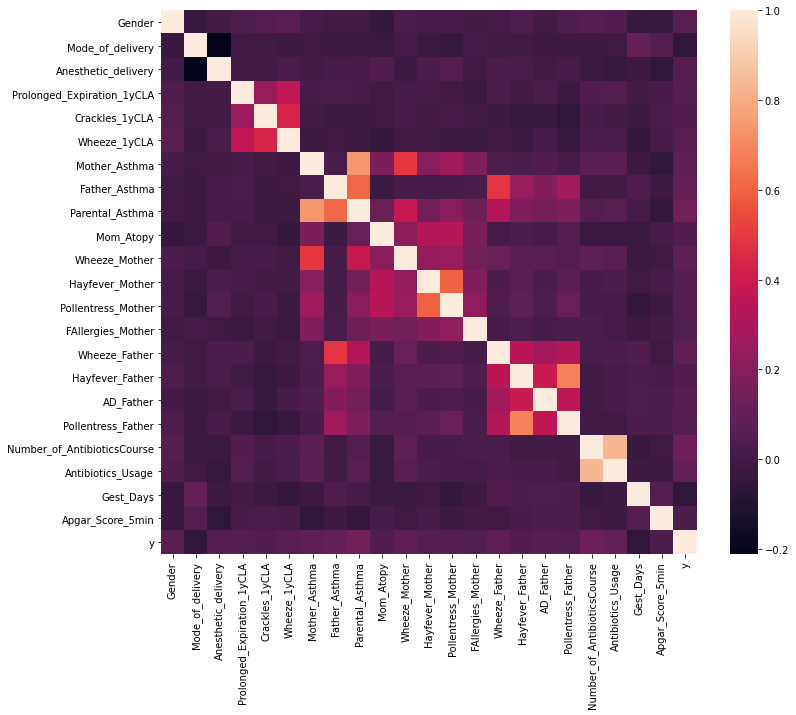

<IPython.core.display.Javascript object>

In [54]:
# Engineer the gender and delivery_mode
df_previous_5y.Gender = df_previous_5y.Gender.replace({"F": 0, "M": 1})
df_previous_5y.Mode_of_delivery = df_previous_5y.Mode_of_delivery.replace(
    {6: 0, 7: 0, 8: 0, 9: 0, 1: 1, 2: 1, 3: 1, 4: 1, 11: 1}
)


# Simplified imputation method but satisified common sense
for col in df_previous_5y.columns[~df_previous_5y.columns.str.contains("^y$")]:
    df_previous_5y[col] = df_previous_5y[col].fillna(df_previous_5y[col].median())

# Correlation overview
plt.figure(figsize=(12, 10))
sns.heatmap(df_previous_ml.corr())

In [115]:
df

,Gender,Mode_of_delivery,Anesthetic_delivery,Prolonged_Expiration_1yCLA,Crackles_1yCLA,Wheeze_1yCLA,Mother_Asthma,Father_Asthma,Parental_Asthma,Mom_Atopy,...,FAllergies_Mother,Wheeze_Father,Hayfever_Father,AD_Father,Pollentress_Father,Number_of_AntibioticsCourse,Antibiotics_Usage,Gest_Days,Apgar_Score_5min,y
Subject_Number,,,,,,,,,,,,,,,,,,,,,
20059,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0,0,276.0,9.0,0.0
20060,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0,0,292.0,6.0,0.0
20061,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,269.0,9.0,0.0
20062,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0,0,279.0,10.0,0.0
20063,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0,0,273.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50859,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0,0,280.0,9.0,0.0
50861,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,275.0,9.0,0.0
50862,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0,0,272.0,9.0,1.0


<IPython.core.display.Javascript object>

#### 3. Baseline Performance

In [253]:
df = df_previous_ml.copy()

# Holdout for test
holdout_df_withtarget1 = df[df.y == 1].sample(frac=0.25, replace=False, random_state=1)
holdout_df_withtarget1.shape
holdout_df_withtarget0 = df[df.y == 0].sample(frac=0.25, replace=False, random_state=1)
holdout_df_withtarget0.shape
holdout_df = pd.concat([holdout_df_withtarget0, holdout_df_withtarget1])
holdout_df

# Define X and y
df_rest = pd.concat(
    [df, holdout_df_withtarget1, holdout_df_withtarget0]
).drop_duplicates(keep=False)
df_rest.shape

X = df_rest.drop("y", 1)
y = df_rest.y

X = pd.DataFrame(
    MinMaxScaler().fit_transform(X), columns=X.columns, index=X.index,
).copy()


# Undersampling
from imblearn.under_sampling import RandomUnderSampler

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy="majority", random_state=2)
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)
y_under.value_counts()


X_train, X_test, y_train, y_test = train_test_split(
    X_under, y_under, test_size=0.2, stratify=y_under, random_state=2
)
X_train.columns
y_test.value_counts()


m1 = "Logistic Regression"
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_prec_score = precision_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Precison of Logistic Regression:", lr_prec_score * 100, "\n")
print(classification_report(y_test, lr_predict))
lr.coef_

(41, 23)

(558, 23)

,Gender,Mode_of_delivery,Anesthetic_delivery,Prolonged_Expiration_1yCLA,Crackles_1yCLA,Wheeze_1yCLA,Mother_Asthma,Father_Asthma,Parental_Asthma,Mom_Atopy,...,FAllergies_Mother,Wheeze_Father,Hayfever_Father,AD_Father,Pollentress_Father,Number_of_AntibioticsCourse,Antibiotics_Usage,Gest_Days,Apgar_Score_5min,y
Subject_Number,,,,,,,,,,,,,,,,,,,,,
20317,0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0,0,292.0,9.0,0.0
40208,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1,1,266.0,9.0,0.0
20672,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,275.0,9.0,0.0
40209,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0,0,273.0,9.0,0.0
20351,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0,0,271.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50852,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,268.0,9.0,1.0
30288,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,3,1,283.0,9.0,1.0
40356,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0,0,287.0,9.0,1.0


(1633, 23)

0.0    124
1.0    124
Name: y, dtype: int64

Index(['Gender', 'Mode_of_delivery', 'Anesthetic_delivery',
       'Prolonged_Expiration_1yCLA', 'Crackles_1yCLA', 'Wheeze_1yCLA',
       'Mother_Asthma', 'Father_Asthma', 'Parental_Asthma', 'Mom_Atopy',
       'Wheeze_Mother', 'Hayfever_Mother', 'Pollentress_Mother',
       'FAllergies_Mother', 'Wheeze_Father', 'Hayfever_Father', 'AD_Father',
       'Pollentress_Father', 'Number_of_AntibioticsCourse',
       'Antibiotics_Usage', 'Gest_Days', 'Apgar_Score_5min'],
      dtype='object')

0.0    25
1.0    25
Name: y, dtype: int64

confussion matrix
[[22  3]
 [12 13]]


Precison of Logistic Regression: 81.25 

              precision    recall  f1-score   support

         0.0       0.65      0.88      0.75        25
         1.0       0.81      0.52      0.63        25

    accuracy                           0.70        50
   macro avg       0.73      0.70      0.69        50
weighted avg       0.73      0.70      0.69        50



array([[ 0.05413341, -0.622417  ,  0.6562773 ,  0.24976938,  0.38135711,
        -0.15589136,  0.08321958,  0.24530196,  0.34308142,  0.00770968,
         0.51698563,  0.13003106,  0.23146236,  0.15443282, -0.05441008,
         0.16298408,  0.24078925,  0.06596055,  0.31868358,  1.03524576,
        -0.60904798,  0.57263843]])

<IPython.core.display.Javascript object>

In [338]:
ml_tuple[2]

,Confusion_Matrix_Summary,Pred_0,Pred_1
K_Nearest_Neigbhors,"{'Pr0': {'Tr0': 20, 'Tr1': 9}, 'Pr1': {'Tr0': ...","{'Tr0': 20, 'Tr1': 9}","{'Tr0': 5, 'Tr1': 16}"
Support_Vector_Machine,"{'Pr0': {'Tr0': 18, 'Tr1': 9}, 'Pr1': {'Tr0': ...","{'Tr0': 18, 'Tr1': 9}","{'Tr0': 7, 'Tr1': 16}"
Naive_Bayes,"{'Pr0': {'Tr0': 24, 'Tr1': 23}, 'Pr1': {'Tr0':...","{'Tr0': 24, 'Tr1': 23}","{'Tr0': 1, 'Tr1': 2}"
Decision_Tree,"{'Pr0': {'Tr0': 17, 'Tr1': 12}, 'Pr1': {'Tr0':...","{'Tr0': 17, 'Tr1': 12}","{'Tr0': 8, 'Tr1': 13}"
Random_Forest,"{'Pr0': {'Tr0': 21, 'Tr1': 9}, 'Pr1': {'Tr0': ...","{'Tr0': 21, 'Tr1': 9}","{'Tr0': 4, 'Tr1': 16}"
eXtreme_Gradient_Boost,"{'Pr0': {'Tr0': 16, 'Tr1': 11}, 'Pr1': {'Tr0':...","{'Tr0': 16, 'Tr1': 11}","{'Tr0': 9, 'Tr1': 14}"
Logistic_Regression,"{'Pr0': {'Tr0': 22, 'Tr1': 12}, 'Pr1': {'Tr0':...","{'Tr0': 22, 'Tr1': 12}","{'Tr0': 3, 'Tr1': 13}"


<IPython.core.display.Javascript object>

confussion matrix: [[20  5]
 [ 9 16]]

The performance score of K_Nearest_Neigbhors: 69.56521739130434 

              precision    recall  f1-score   support

         0.0       0.69      0.80      0.74        25
         1.0       0.76      0.64      0.70        25

    accuracy                           0.72        50
   macro avg       0.73      0.72      0.72        50
weighted avg       0.73      0.72      0.72        50

confussion matrix: [[18  7]
 [ 9 16]]

The performance score of Support_Vector_Machine: 66.66666666666666 

              precision    recall  f1-score   support

         0.0       0.67      0.72      0.69        25
         1.0       0.70      0.64      0.67        25

    accuracy                           0.68        50
   macro avg       0.68      0.68      0.68        50
weighted avg       0.68      0.68      0.68        50

confussion matrix: [[24  1]
 [23  2]]

The performance score of Naive_Bayes: 14.285714285714285 

              precision    recall  

UnboundLocalError: local variable 'index_name' referenced before assignment

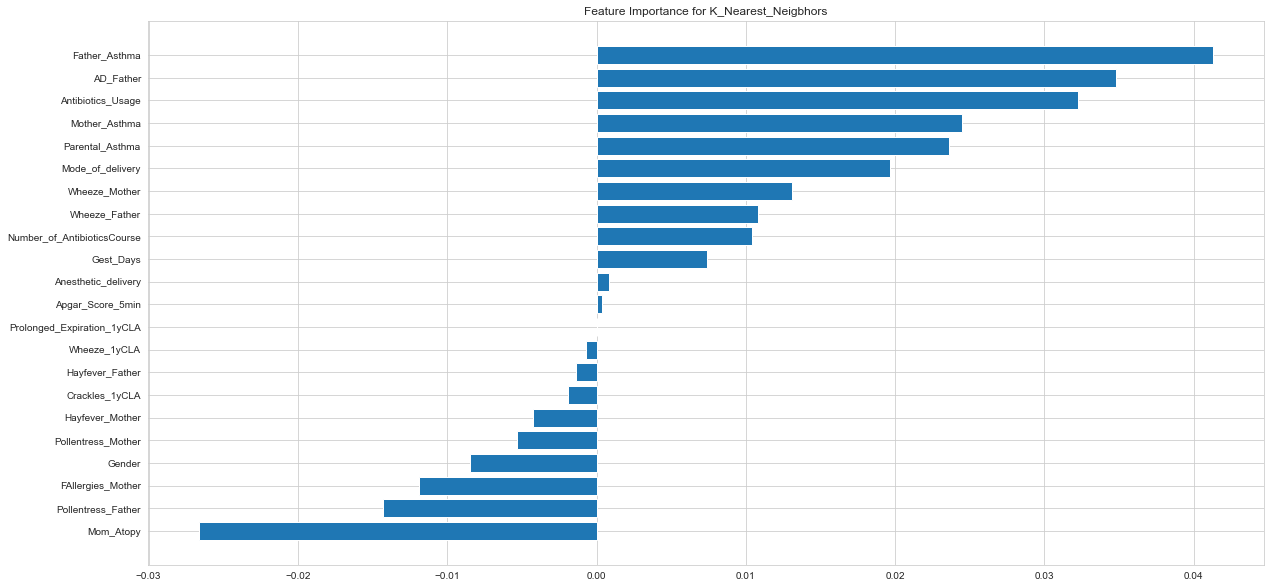

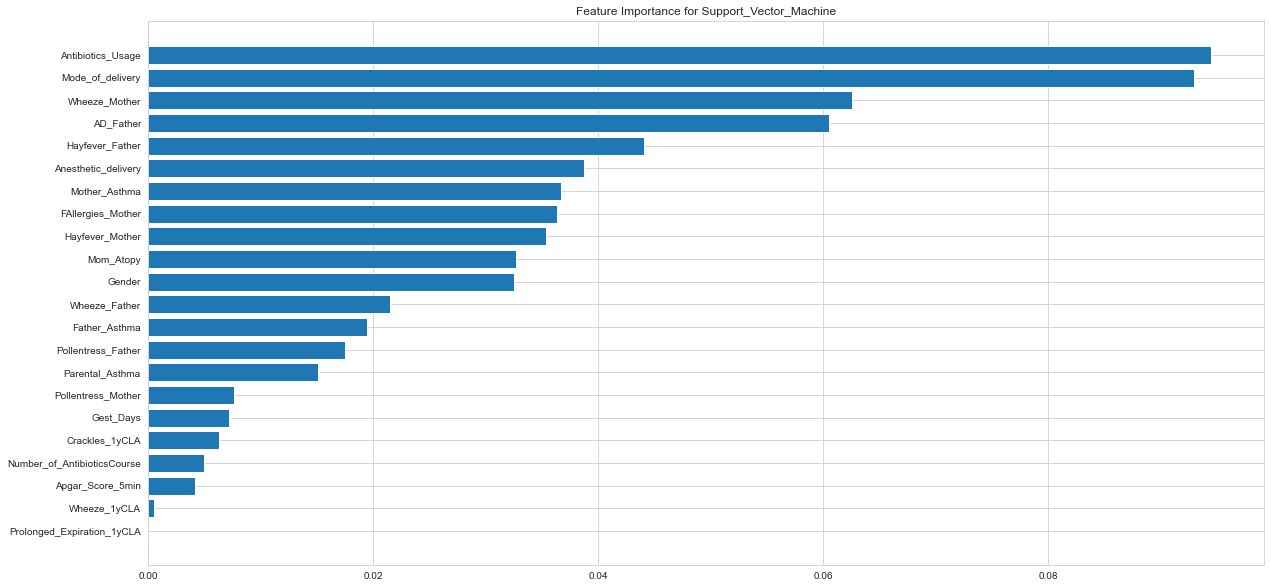

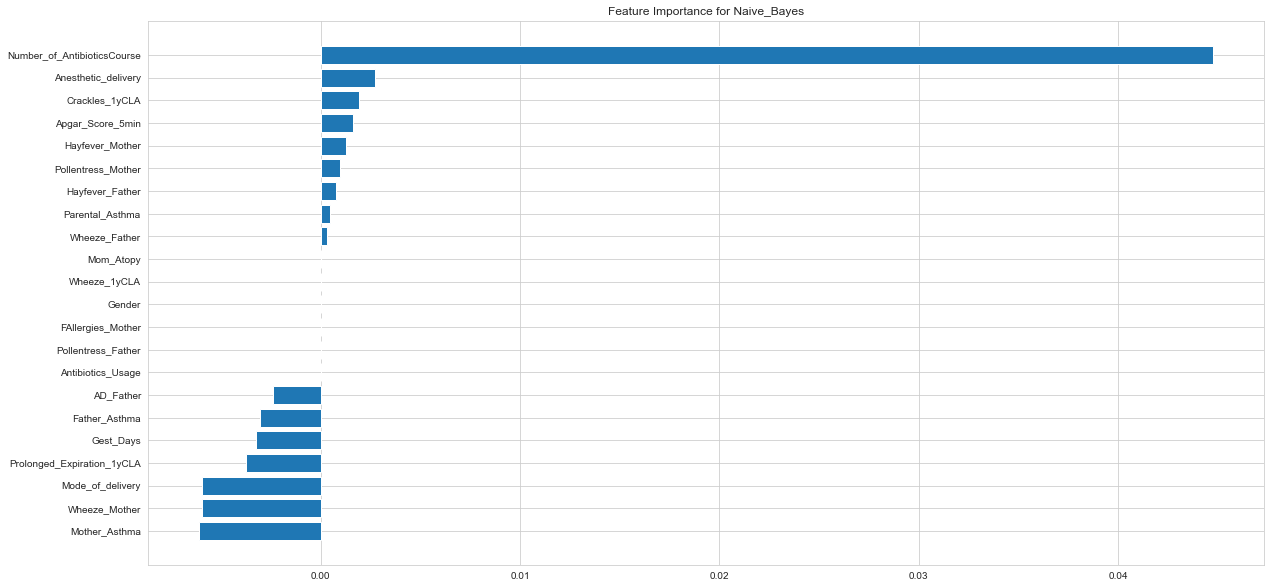

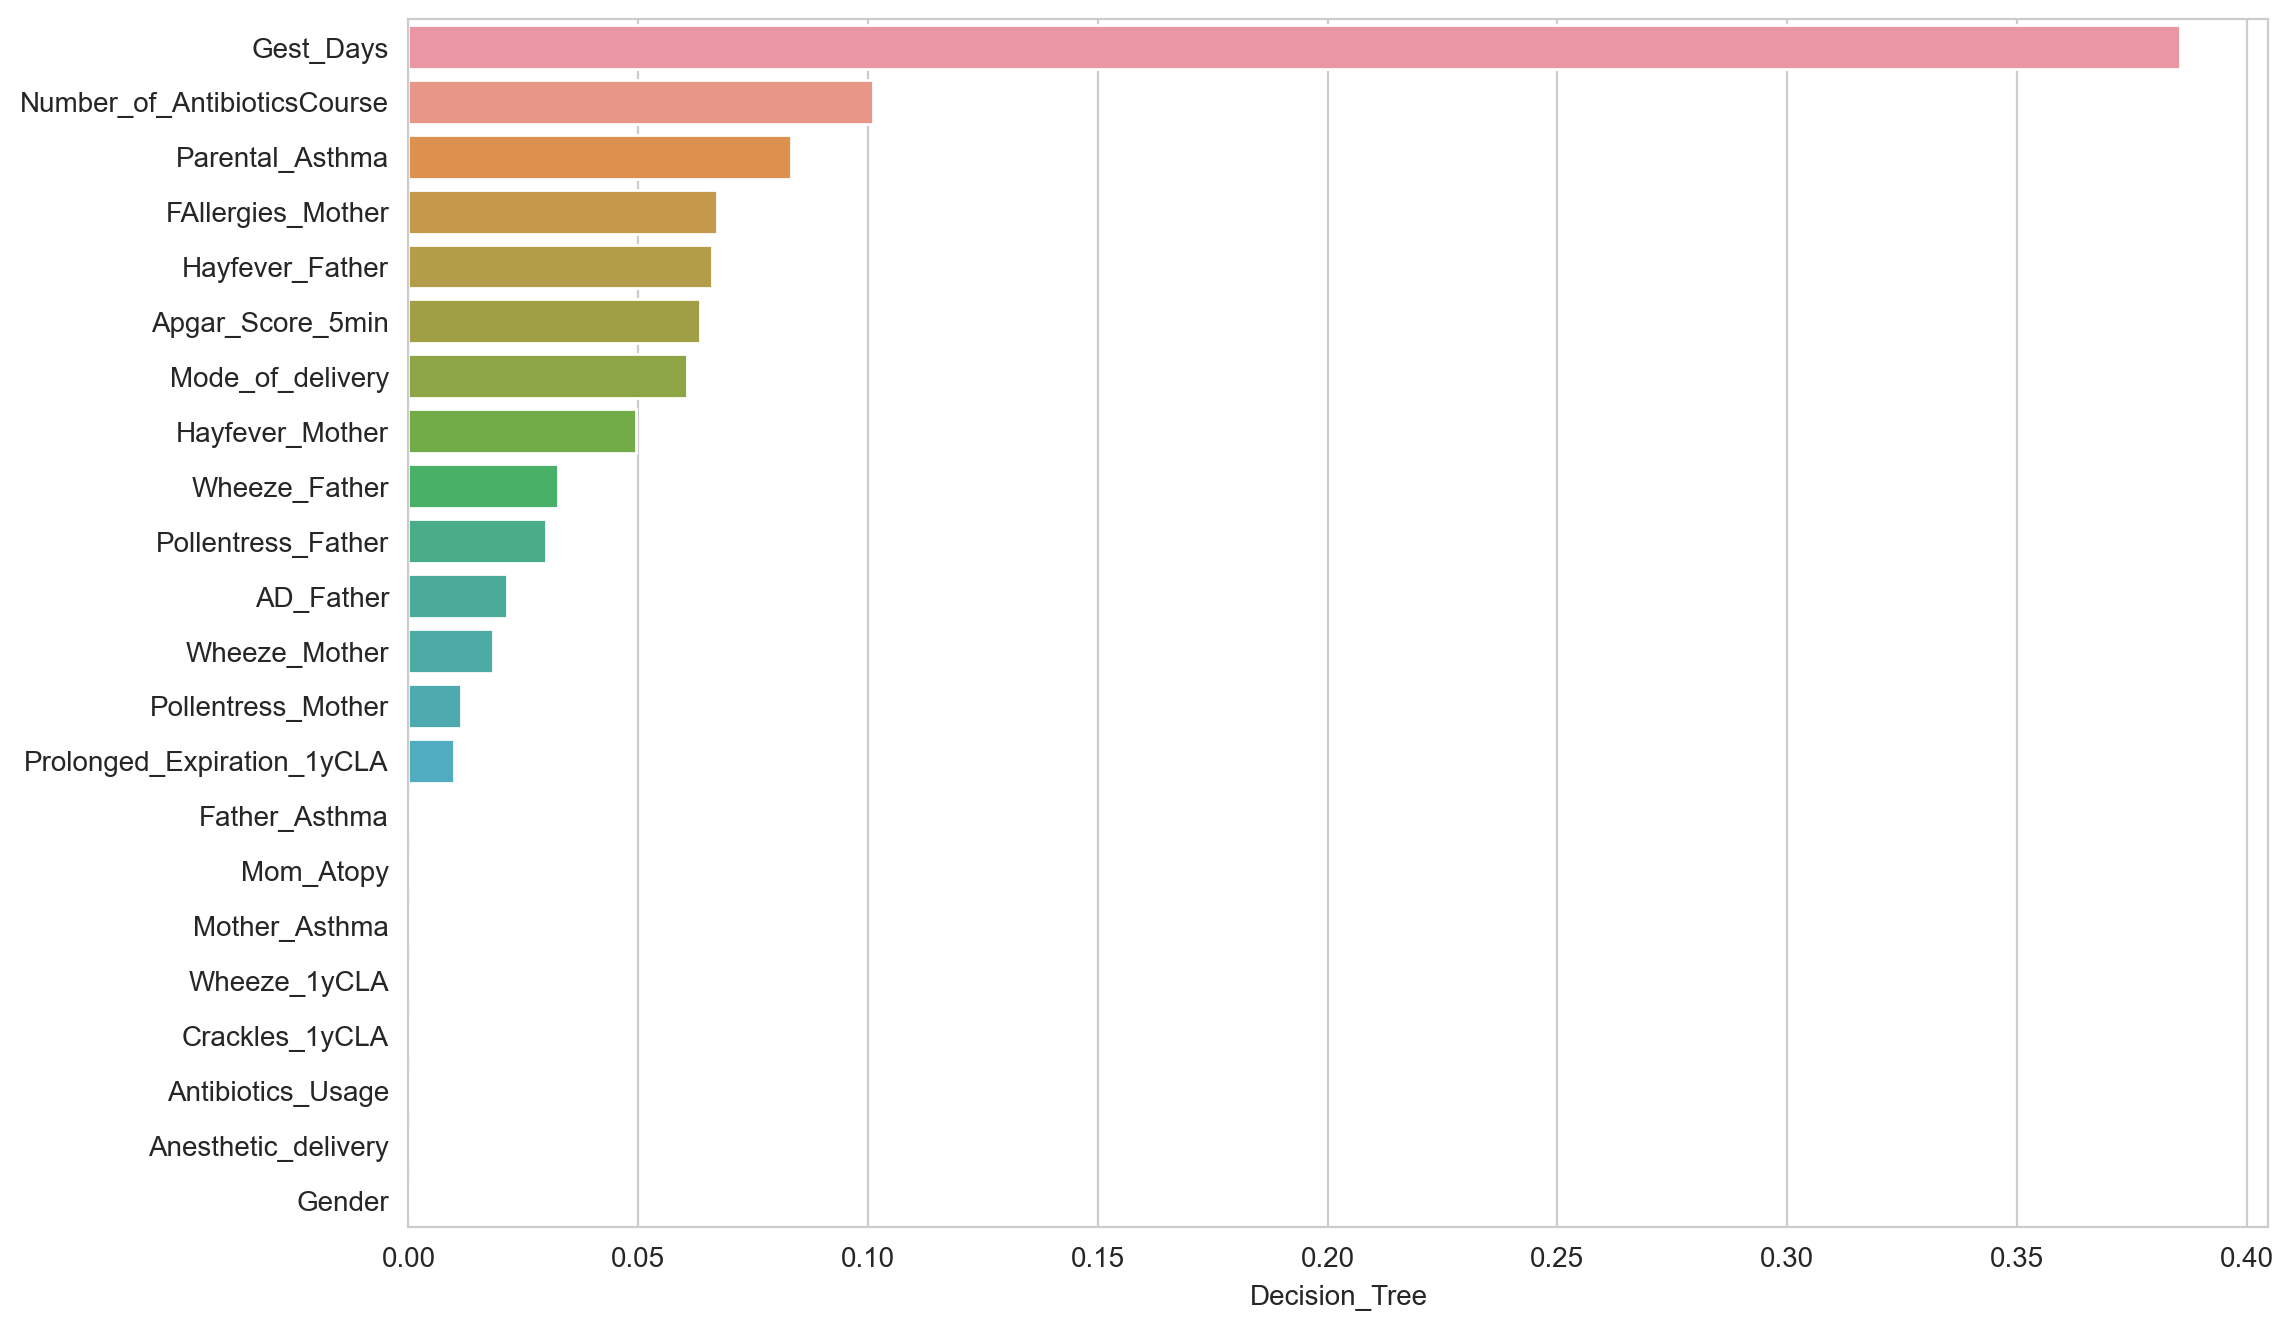

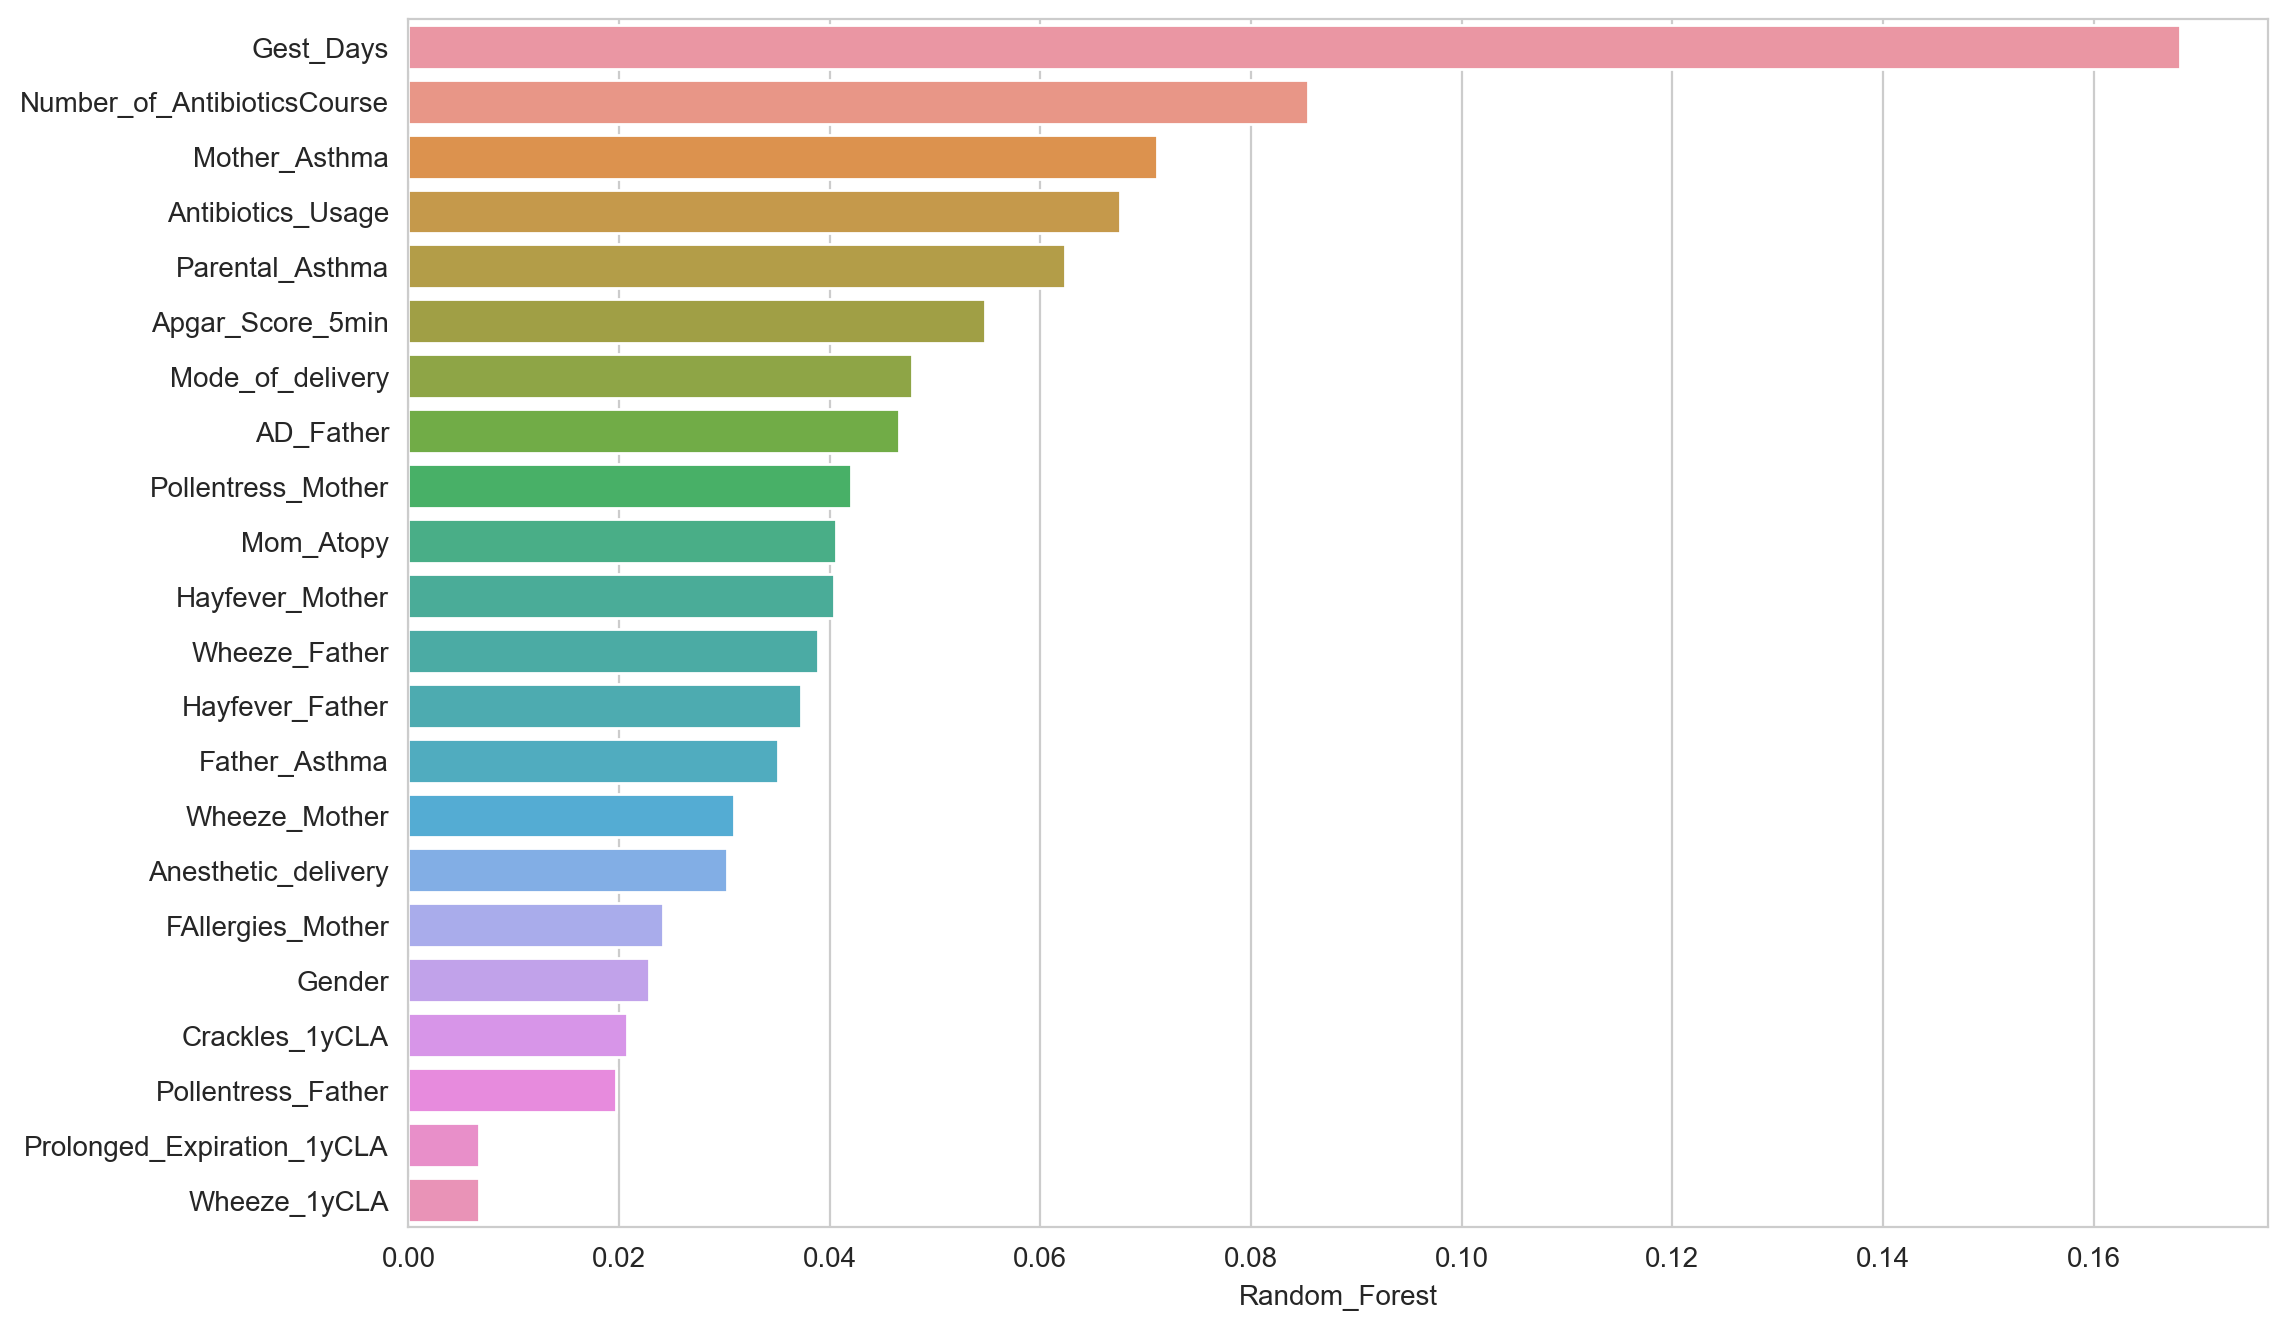

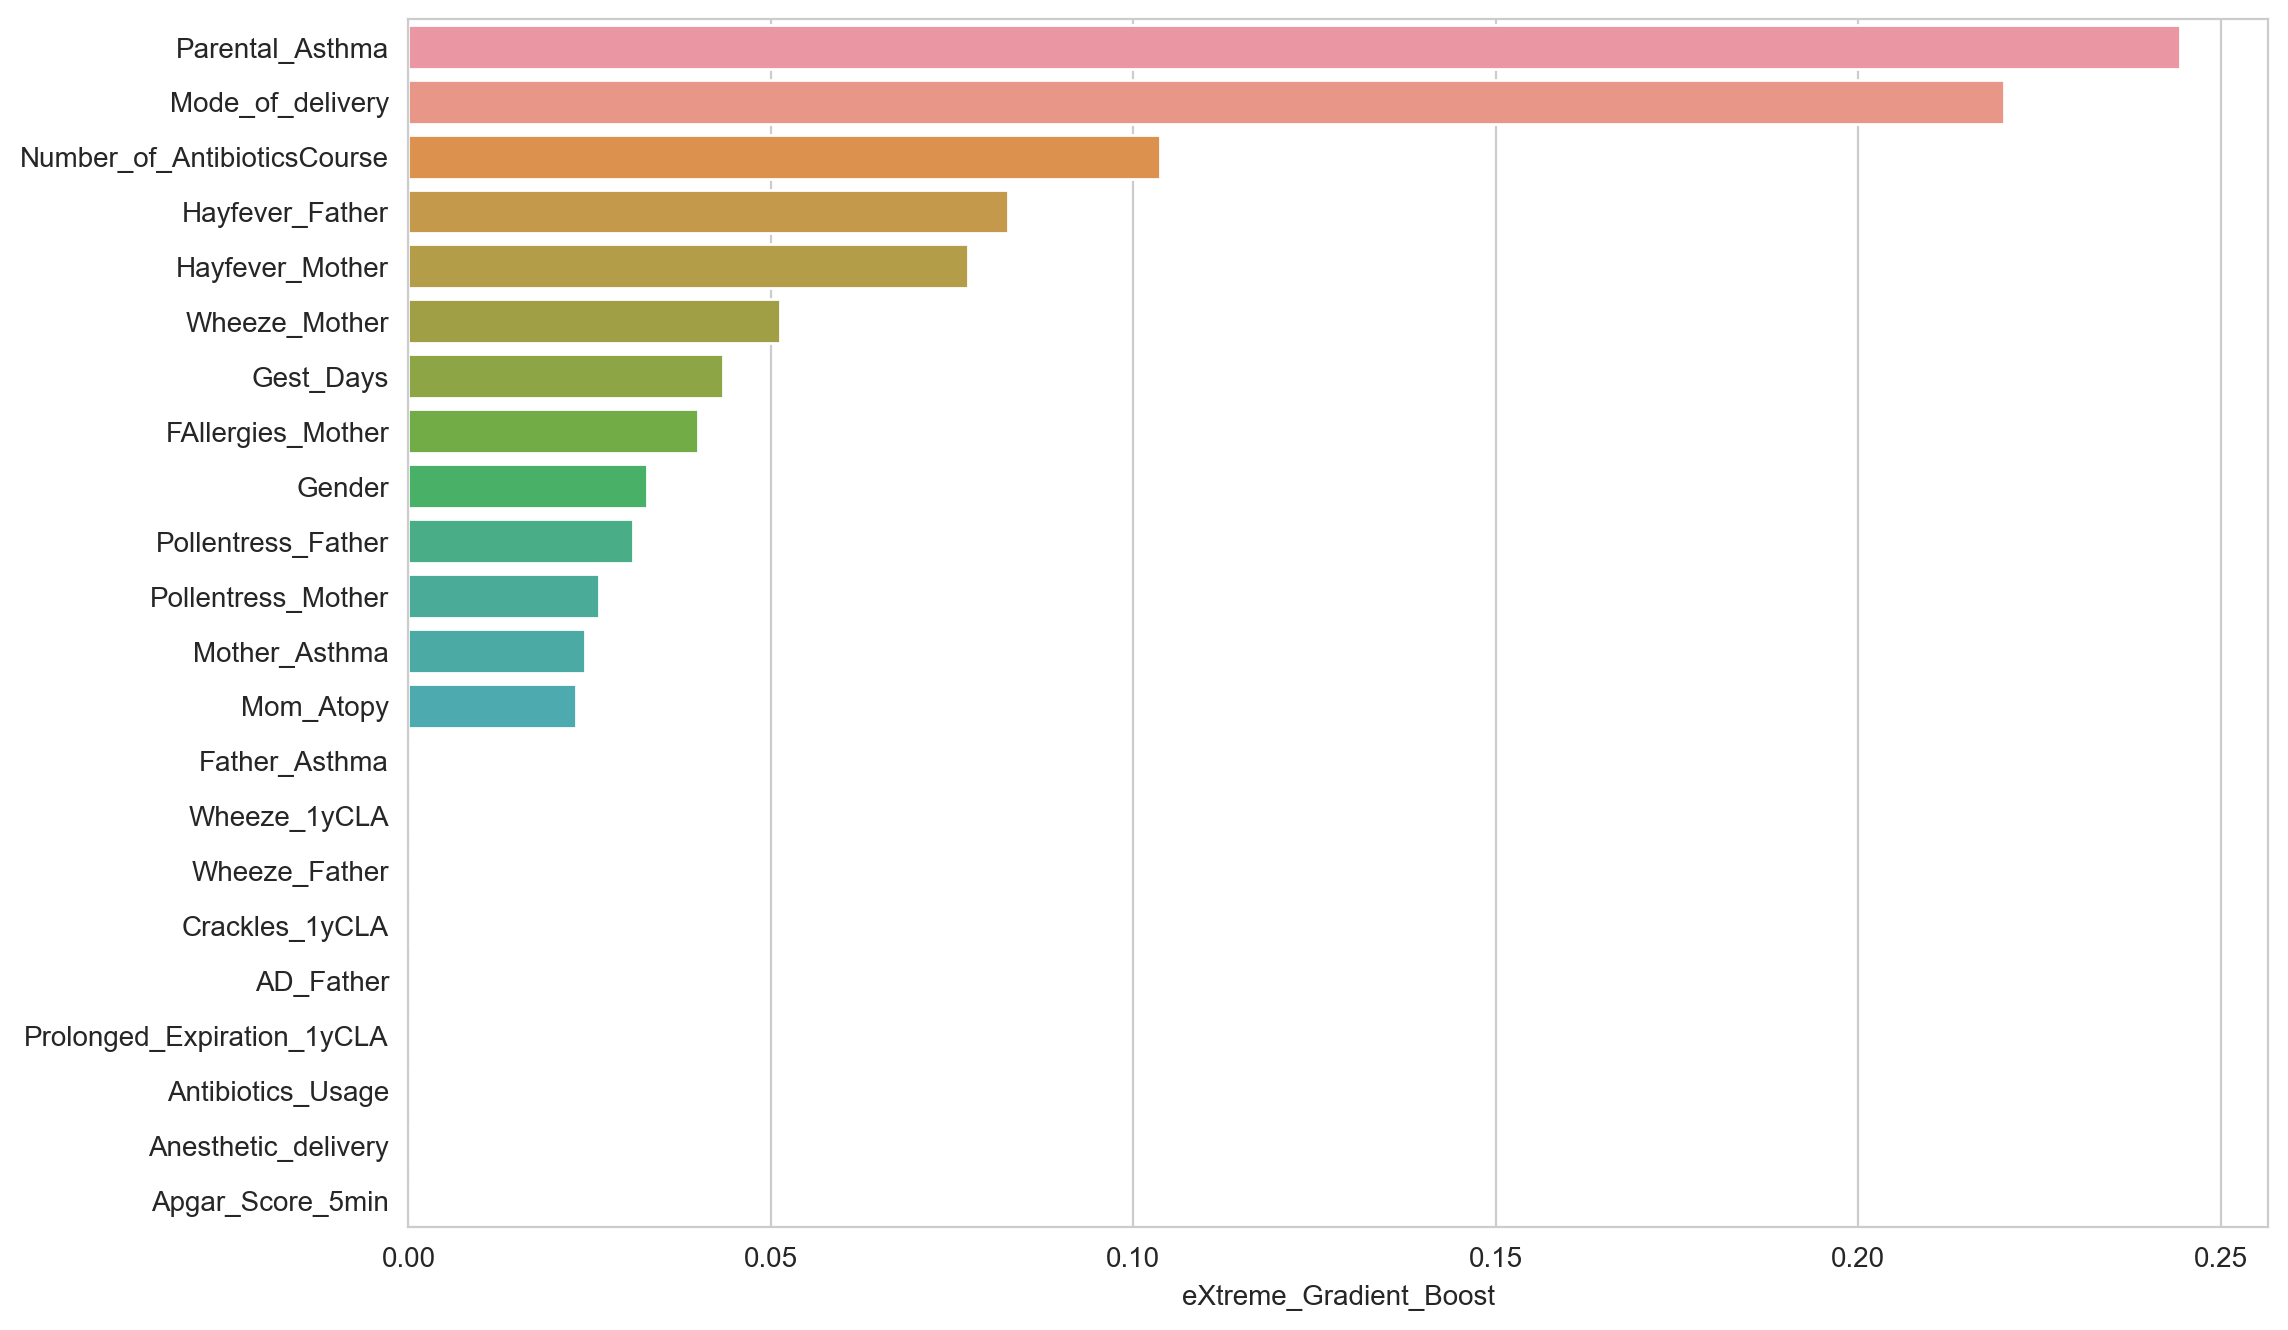

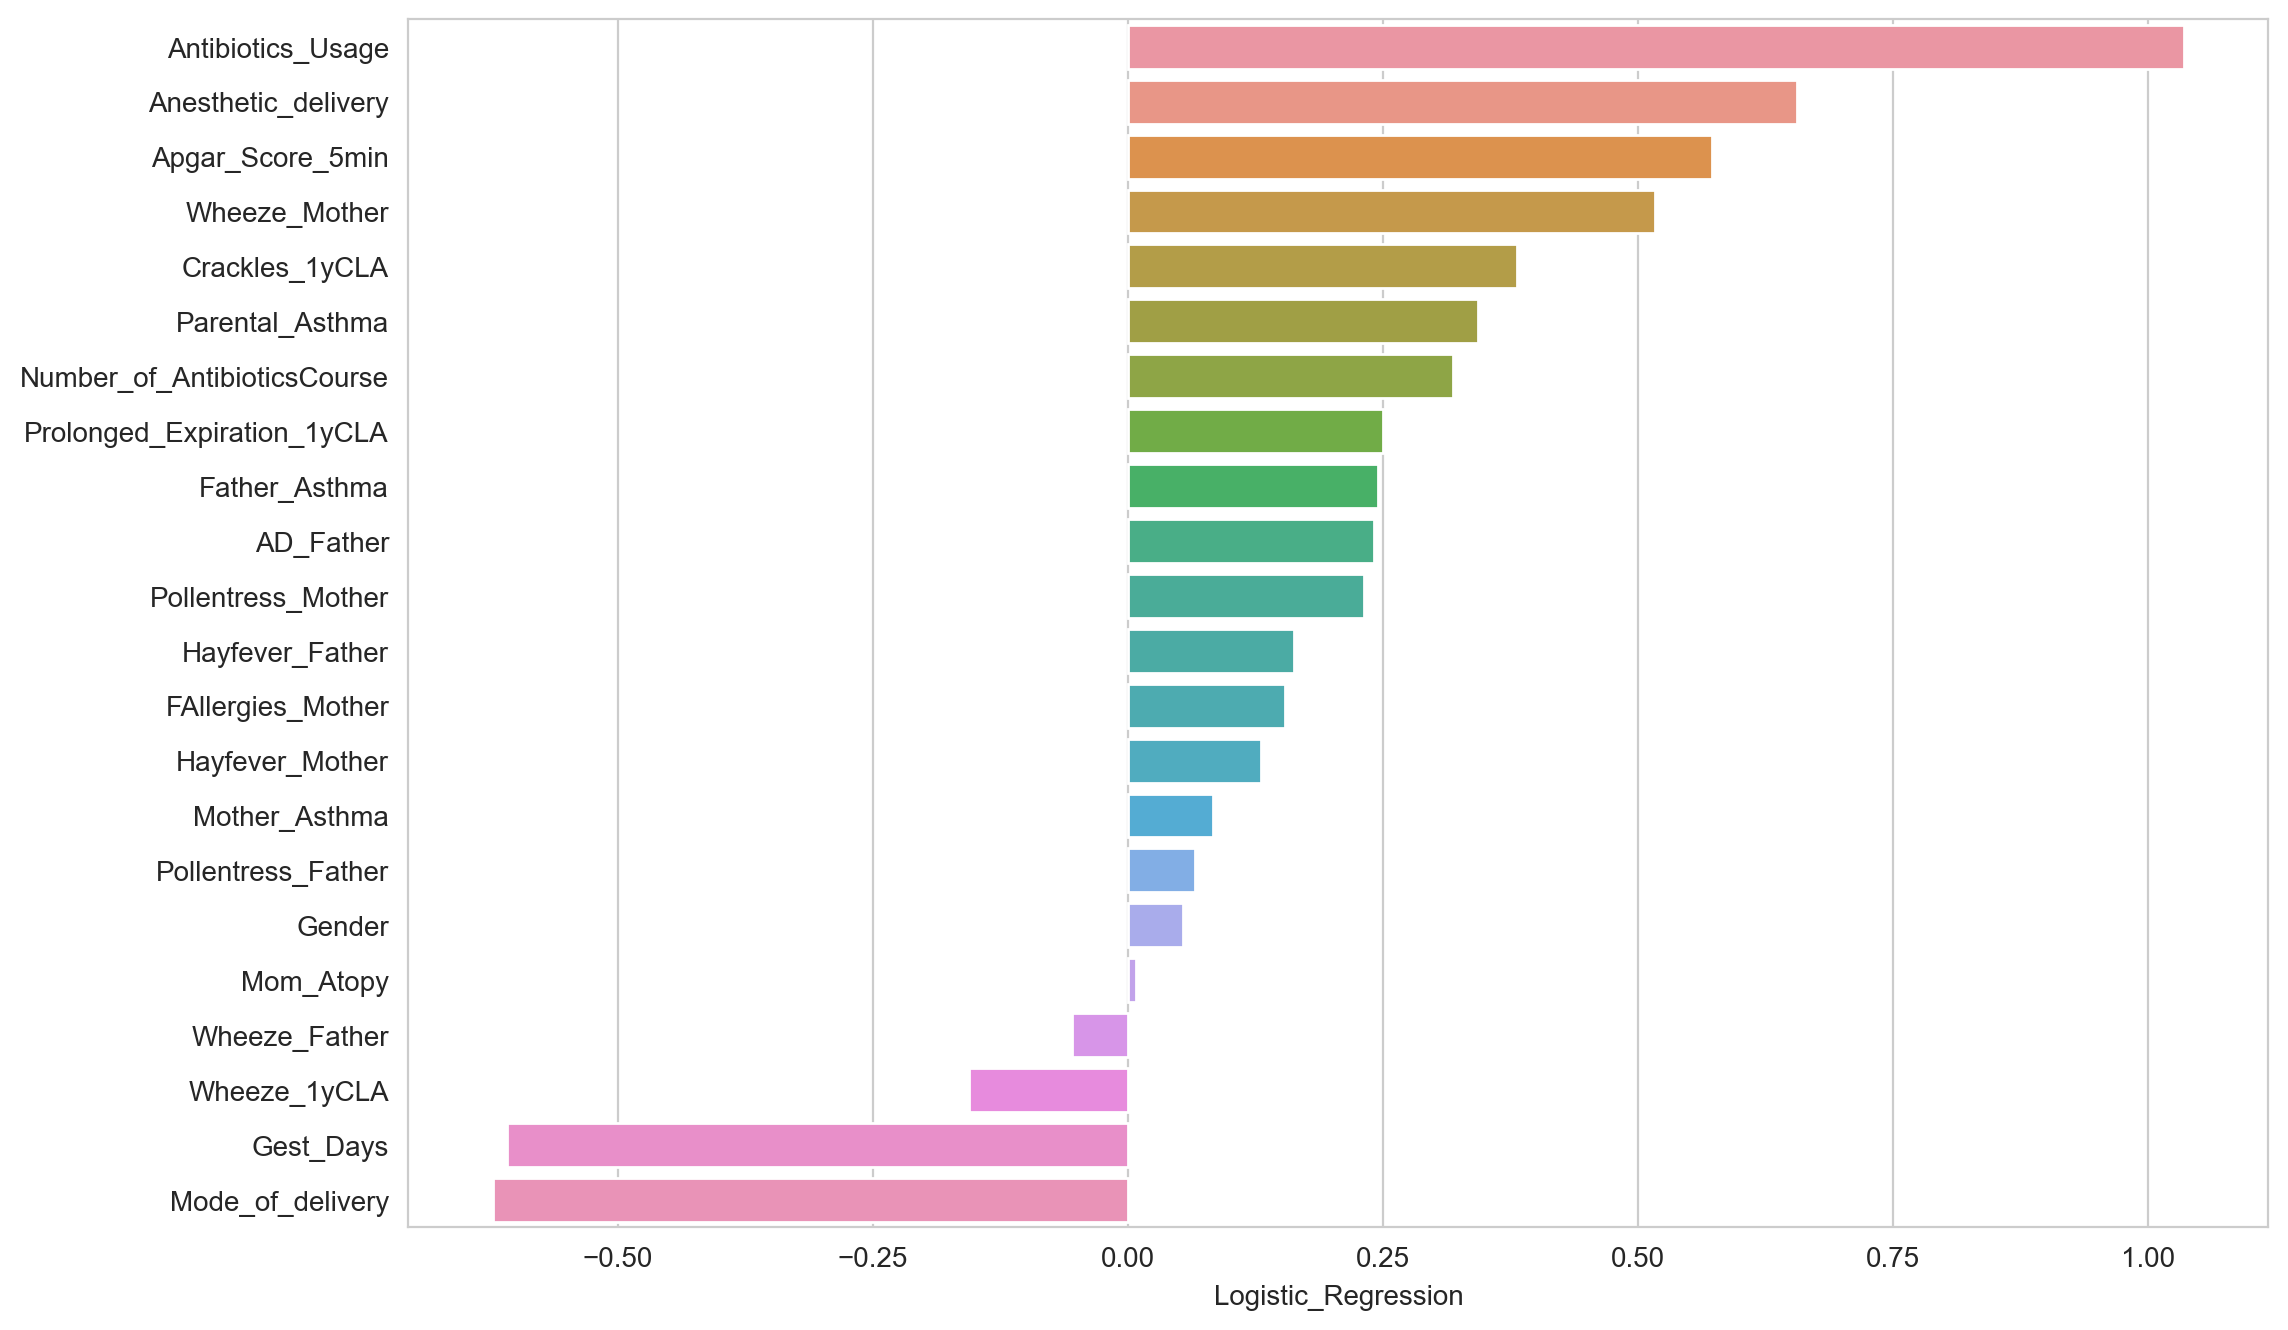

<IPython.core.display.Javascript object>

In [332]:
ml_tuple = ml_run(X_train, X_test, y_train, y_test)

###  Test Run of Transformers

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=0)

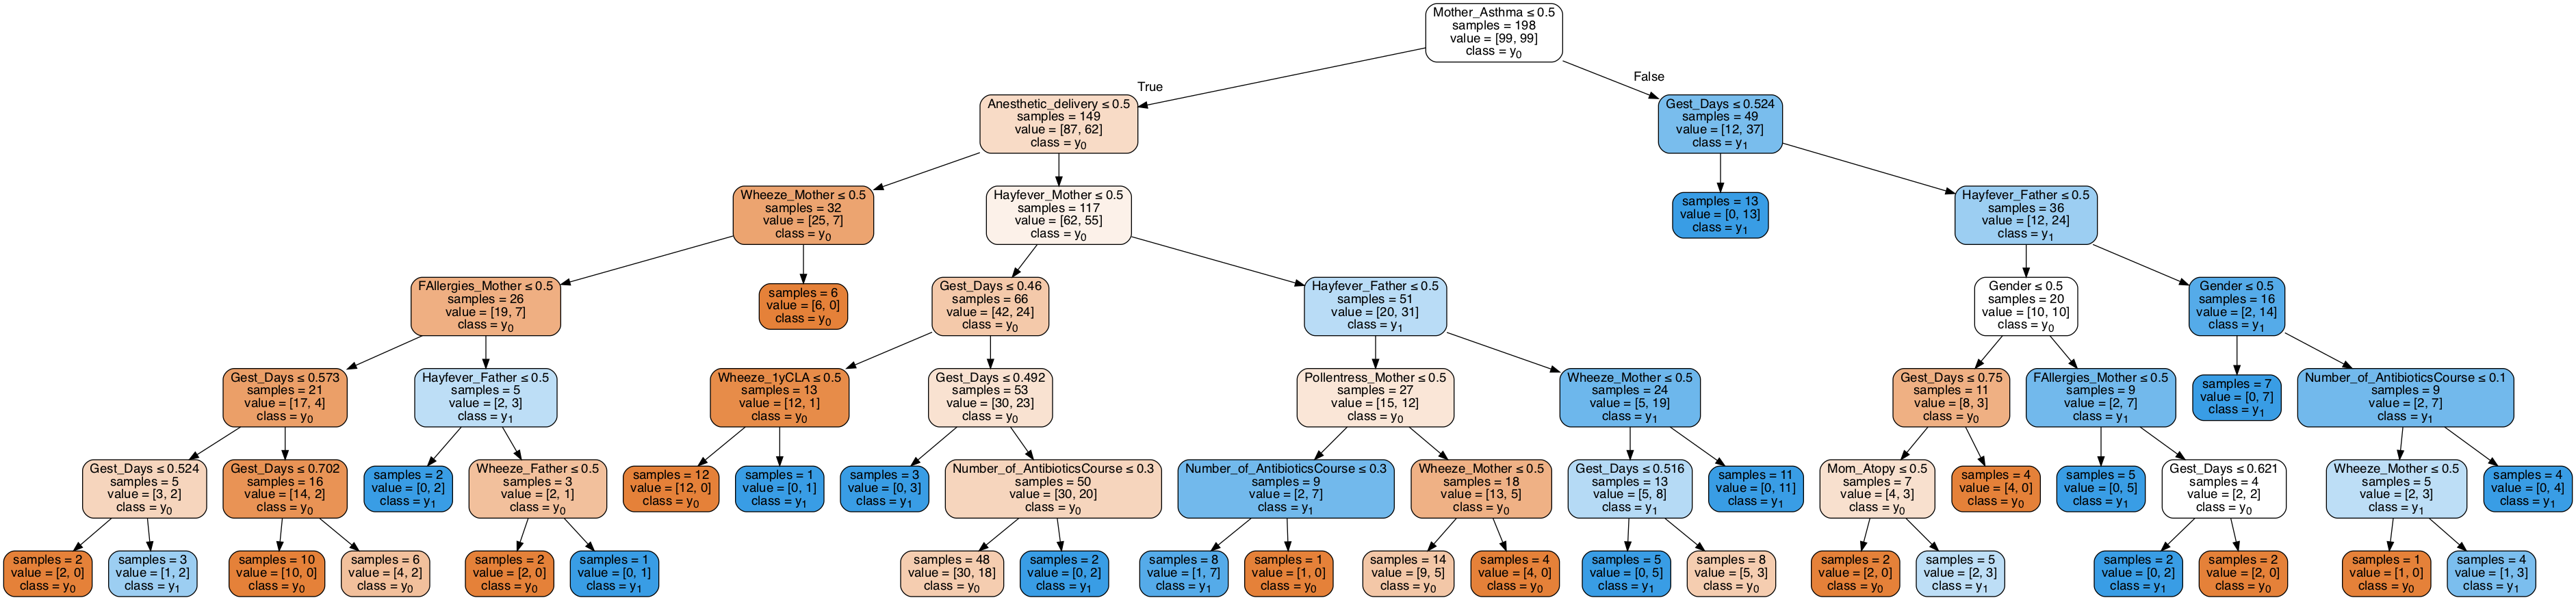

<IPython.core.display.Javascript object>

In [90]:
model_dt = "Decision_Tree"
dt = DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=6)
dt.fit(X_train, y_train)
predicted = dt.predict(X_test)
# Visualizing of decision path
col_names_list = list(X.columns.values)
dot_data = StringIO()
export_graphviz(
    dt,
    out_file=dot_data,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=col_names_list,
    impurity=False,
    # proportion=True,
    # precision=2,
    # node_ids=True,
    class_names=True,
    # leaves_parallel=False,
    # rotate=True,
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Now begins the INTERESTING ML Journey!

In [ ]:
print(view_module_functions(UT))

In [ ]:
X_summary = df_summary(X)
X_summary.sort_values(by="Variance")

In [ ]:
y_prop = view_y_proportions(df_ml_scaled, df_ml_scaled.columns[:-1], 0)

view_y_proportions(df_ml_scaled, df_ml_scaled.columns[:-1], 0.5)[
    view_y_proportions(
        df_ml_scaled, df_ml_scaled.columns[:-1], 0.5
    ).Asthma_Proportion_over_thresh
    < 10
]


view_y_proportions(df_ml_scaled, df_ml_scaled.columns[:-1], 0.3)[
    view_y_proportions(
        df_ml_scaled, df_ml_scaled.columns[:-1], 0.3
    ).Asthma_Proportion_over_thresh
    >= 10
]

y_prop.loc["Prenatal_Hypotension"]

#### Statistic Analysis for F10min Mask related to Asthma Outcome

Pingouin, statsmodel(table,proportion), scipy, sklearn

In [ ]:
# Three Package to obtain P value for chi square test for F10min Oxygen Mask Stats
# Scipy Based
# One
import pingouin as pg

expected, observed, stats = pg.chi2_independence(
    df_ml_scaled, x="F10min_Oxygen_Mask", y="y", correction=False
)

observed, expected, stats

_, _, stats = pg.chi2_independence(
    df_ml_scaled, x="Prenatal_Hypotension", y="y", correction=False
)

stats

In [ ]:
# Two: Scipy - Required to create contingency table as input
# Need to create a contingency table first, which can be realized using pd.crosstab

from scipy.stats import chi2_contingency

contingency_f10m_Oxy = pd.crosstab(df_ml_scaled.F10min_Oxygen_Mask, df_ml_scaled.y)

chi2_contingency(contingency_f10m_Oxy.values, correction=False)

print(
    "In statistics, Yates's correction for continuity (or Yates's chi-squared test) is used in certain situations when testing for independence in a contingency table. It aims at correcting the error introduced by assuming that the discrete probabilities of frequencies in the table can be approximated by a continuous distribution (chi-squared). In some cases, Yates's correction may adjust too far, and so its current use is limited."
)

In [ ]:
# Three: Statsmodel
import statsmodels.api as sm

# sm_f10oxy_table = sm.stats.Table(contingency_f10m_Oxy.values)
sm_f10oxy_table = sm.stats.Table.from_data(df_ml_scaled[["F10min_Oxygen_Mask", "y"]])

print(f"Observed Table:\n {sm_f10oxy_table.table_orig}")
print(f"Expected Table:\n {sm_f10oxy_table.fittedvalues}")
print(
    f"Pearson Residuals:\n {sm_f10oxy_table.resid_pearson}"
)  # view Residuals which identify particular cells that most strongly violate independence

print("\n----------------Independence/Association test----------------")
print("\nNominal Association:\n", sm_f10oxy_table.test_nominal_association())
print("\nOrdinal Association:\n", sm_f10oxy_table.test_ordinal_association())
print(f"\nChi Square Contribution:\n{sm_f10oxy_table.chi2_contribs}")
print(
    "\n----------------Local Odd Ratio----------------:\n{}".format(
        sm_f10oxy_table.local_oddsratios
    )
)
print(
    f"Contingency table odd ratio: {sm.stats.Table2x2(contingency_f10m_Oxy.values).oddsratio}"
)


# Three-2: Statsmodel Proportion Test
# Proportion Chi-Square Test
print("\n----------------Proportion Chi-Square Test----------------")
from statsmodels.stats.proportion import (
    proportions_chisquare,
    proportion_effectsize,
)  # No indexing needed

f10mask_no_group_observation = np.sum(df_ml_scaled.F10min_Oxygen_Mask != 1)
f10mask_yes_group_observation = np.sum(df_ml_scaled.F10min_Oxygen_Mask == 1)

f10mask_no_asthma_count = np.sum(df_ml_scaled[df_ml_scaled.F10min_Oxygen_Mask != 1].y)
f10mask_yes_asthma_count = np.sum(df_ml_scaled[df_ml_scaled.F10min_Oxygen_Mask == 1].y)

(chi2, chi2_p_value, expected) = proportions_chisquare(
    count=[f10mask_no_asthma_count, f10mask_yes_asthma_count],
    nobs=[f10mask_no_group_observation, f10mask_yes_group_observation],
)

print(
    "\nAsthma Outcome Proportion Chi Square Test:\nchi2: %f \t p_value: %f"
    % (chi2, chi2_p_value)
)


asthma_no_group_observation = np.sum(df_ml_scaled.y != 1)
asthma_yes_group_observation = np.sum(df_ml_scaled.y == 1)

asthma_no_f10mask_count = np.sum(df_ml_scaled[df_ml_scaled.y != 1].F10min_Oxygen_Mask)
asthma_yes_f10mask_count = np.sum(df_ml_scaled[df_ml_scaled.y == 1].F10min_Oxygen_Mask)

(chi2, chi2_p_value, expected) = proportions_chisquare(
    count=[asthma_no_f10mask_count, asthma_yes_f10mask_count],
    nobs=[asthma_no_group_observation, asthma_yes_group_observation],
)

print(
    "\nF10m Mask Outcome Proportion Chisquare Test:\nchi2: %f \t p_value: %f"
    % (chi2, chi2_p_value)
)

In [ ]:
print("Discrepancy: P-value of chi square test between Scipy and Statsmodel")

print(
    f"\nFor Scipy with correction:\npvalue: {chi2_contingency(contingency_f10m_Oxy.values)[1]}"
)
print(
    f"\nFor Scipy without correction:\npvalue: {chi2_contingency(contingency_f10m_Oxy.values, correction=False)[1]}"
)

print(f"\nFor Statsmodel:\n{sm_f10oxy_table.test_nominal_association()}")


print(
    "\nExplanation:\n\nScipy uses the continuity correction, Statsmodels does not. If you pass correction=False to the scipy test, then the results will be identical."
)

In [ ]:
# Four: Sklearn - CHI2
from sklearn.feature_selection import chi2

chi2(df_ml_scaled.F10min_Mask_Ventilation.values.reshape(-1, 1), df_ml_scaled.y)

### ML Libraries

In [ ]:
# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Feature selection
from sklearn.feature_selection import (
    SelectPercentile,
    SelectKBest,
    SelectFwe,
    SelectFpr,
    SelectFromModel,
    chi2,
    mutual_info_classif,
    f_classif,
    SequentialFeatureSelector,
    RFECV,
)
from sklearn.inspection import permutation_importance

# Imbalance Learn
from imblearn.over_sampling import RandomOverSampler

# Models
from sklearn.linear_model import LogisticRegression, Lasso, LassoLarsCV, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Ensemble
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Metrics, Parameters, Evaluation
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    train_test_split,
)


from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_curve,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Feature Selection   <a id='0'></a> 

1. [Lasso](#lasso)
2. [Chi2](#chi2)
3. [f_value](#f_classif)
4. [FalsePositiveRate](#fpr)
5. [p_value](#fwe)
6. [mutual_information](#mutal)
7. [Recursive Feature Elimination](#RFE)
8. [SelectFromModel](#selm)
9. [permutation_importance](#permutation)
10. [SequentialFeatureSelector](#sequentialgreed)

### Feature Engineering
1. [PCA](#pca)
2. [FeatureAgglomeration](#clusteragglomeration)
3. [Derived_New_Features_with_Expertise_and_Logic](#derivenewfeature)

[return](#top)

#### (1) Lasso - Observation - 1

In [ ]:
# plt.style.available
# plt.style.use("seaborn-bright")

In [ ]:
# Automatic Alphas with StratifiedKfold
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1015)
model = LassoLarsCV(cv=skf).fit(X, y)

In [ ]:
# Automatic Alphas with StratifiedKfold
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1015)
model = LassoLarsCV(cv=skf).fit(X, y)

fig, ax = plt.subplots(figsize=(20, 12))
columns_of_total = X.shape[1]
start = 0
end = X.shape[1]
number_of_display = end - start

cm = iter(plt.get_cmap("Set1")(np.linspace(0, 1, number_of_display)))
for i in range(start, end):
    c = next(cm)
    _ = ax.plot(
        model.alphas_, model.coef_path_.T[:, i], c=c, alpha=0.8, label=X.columns[i]
    )


lassocv_df = pd.DataFrame(
    data=model.coef_path_.T, columns=X.columns, index=model.alphas_
)

y_pos_ser = lassocv_df.iloc[-1:].T.iloc[:, 0][lassocv_df.iloc[-1:].T.iloc[:, 0] != 0]
x_pos = float(lassocv_df.iloc[-1:].T.columns.values)
x_pos_list = [x_pos for i in range(len(y_pos_ser))]

for x_t, y_t, text in zip(x_pos_list, y_pos_ser.values, y_pos_ser.index):
    axtxt = ax.text(
        x_t - 0.00005,
        y_t,
        text,  # Used to format it K representation
        color="black",
        rotation="horizontal",
        size="large",
    )

ax.legend(X.columns[start:end], bbox_to_anchor=(1, 1))

plt.xlim([0.00020, 0.00105])
plt.ylabel("Lasso Regression CV")
plt.xlabel("Regularization Factor - Alphas")
plt.title("Regression Coefficient Progression for Lasso Path")

#fig.savefig("../images/lasso_progression",dpi=300,bbox_inches='tight')


In [ ]:
view_y_proportions(
    df_for_ml, lassocv_df.sum()[lassocv_df.sum() != 0].sort_values().index, 0.5
)

#### Lasso - Observation - 2 - All features decreasing pattern   <a id='lasso'></a>

[return](#0)

In [ ]:
coef_dict = {}
for alp in tqdm(np.arange(0.000001, 0.0009, 0.000005)):
    lasso_model = Lasso(alpha=alp).fit(X, y)
    coef_dict[alp] = list(lasso_model.coef_)

res = pd.DataFrame(data=coef_dict.values(), columns=X.columns, index=coef_dict.keys()).T

In [ ]:
# For those with bitter coefficient (impact)
res[0.000001][abs(res[0.000001]) > 0.05].sort_values().index
view_y_proportions(
    df_for_ml, res[0.000001][abs(res[0.000001]) > 0.05].sort_values().index, 0.5
)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# sns.color_palette("YlOrBr", as_cmap=True)
# fig, ax = plt.subplots(figsize=(40, 40))
# sns.heatmap(res.iloc[:, :], vmax=0.2, vmin=-0.2, cmap="vlag", ax=ax)

#### (2) Chi2 & SelectPercentile  <a id='chi2'></a>

[return](#0)

In [ ]:
clf = Pipeline([("chi2", SelectPercentile(chi2)), ("rfc", RandomForestClassifier())])

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1024)

In [ ]:
# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 5, 10, 15, 20, 30, 40, 60, 80, 90, 100)

for percentile in tqdm(percentiles):
    clf.set_params(chi2__percentile=percentile)
    this_scores = cross_val_score(clf, X, y, cv=skf, scoring="roc_auc")
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())


plt.figure(figsize=(12, 8))
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    "Performance of the RandomForest-Chi2 varying the percentile of features selected"
)
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Precision Score")
plt.axis("tight")
plt.show()

In [ ]:
chi_perc = SelectPercentile(chi2, percentile=30)
chi_perc.fit_transform(X, y)

In [ ]:
chi_perc = SelectPercentile(chi2, percentile=30)
chi_perc.fit_transform(X, y)

# X.columns[chi_perc.get_support()]
chi_perc.get_feature_names_out()
len(chi_perc.get_feature_names_out())

chi2_res = pd.DataFrame(
    [list(chi_perc.pvalues_), list(chi_perc.scores_)],
    index=["P_value", "Scores"],
    columns=X.columns,
).T

chi2_res[chi2_res.P_value < 0.05]

view_y_proportions(df_ml_scaled, chi2_res[chi2_res.P_value < 0.05].index, 0)

In [ ]:
view_y_proportions(df_ml_scaled, chi2_res[chi2_res.P_value < 0.05].index, 0)

#### (3) F_classif & SelectPercentile  <a id='f_classif'></a>

[return](#0)

In [ ]:
clf = Pipeline([("fvalue", SelectKBest(f_classif)), ("xgb", XGBClassifier())])

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1020)

In [ ]:
# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
k_best = (10, 20, 25, 30, 35, 40, 50, 60, 70, 90, "all")

for i in tqdm(k_best):
    clf.set_params(fvalue__k=i)
    this_scores = cross_val_score(clf, X, y, cv=skf, scoring="roc_auc")
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())


plt.figure(figsize=(12, 8))
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the XGB-f_value varying the number of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Precision Score")
plt.axis("tight")
plt.show()

In [ ]:
f_bestk = SelectKBest(f_classif, k=40)
f_bestk.fit_transform(X, y)

f_bestk.get_feature_names_out()
len(f_bestk.get_feature_names_out())

f_res = pd.DataFrame(
    [list(chi_perc.pvalues_), list(chi_perc.scores_)],
    index=["P_value", "Scores"],
    columns=X.columns,
).T

f_res[f_res.P_value < 0.05]

f_res[f_res.Scores > 5]

#### (4) False Positive Rate  <a id='fpr'></a>

[return](#0)

In [ ]:
fpr_res = SelectFpr(score_func=chi2, alpha=0.15)
fpr_res.fit_transform(X, y).shape
col_temp = (
    pd.DataFrame(fpr_res.pvalues_.reshape(1, len(X.columns)), columns=X.columns)
    .T.loc[:, 0][
        pd.DataFrame(
            fpr_res.pvalues_.reshape(1, len(X.columns)), columns=X.columns
        ).T.loc[:, 0]
        <= 0.15
    ]
    .index
)

In [ ]:
d1 = fpr_res.fit_transform(X, y)
d2 = X[col_temp].values
np.sum(d1 != d2)
col_temp

In [ ]:
view_y_proportions(df_ml_scaled, col_temp, 0.4)

In [ ]:
pg.chi2_independence(df_ml_scaled, x="PSS_18week_High_Stress", y="y", correction=False)

In [ ]:
def view_pOR_value(df, feature):
    """View the stats for feature impact
    """
    stats_res = pg.chi2_independence(df, x=feature, y="y", correction=False)
    print(f"\n----------------Expected----------------:\n{stats_res[0]}")
    print(f"\n----------------Observed----------------:\n{stats_res[1]}")
    print(f"\n----------------Stats----------------:\n{stats_res[2]}")

    sm_table = sm.stats.Table.from_data(df[[feature, "y"]])
    print(
        f"\n----------------Chi Square Contribution----------------:\n{sm_table.chi2_contribs}"
    )
    print(
        "\n----------------Local Odd Ratio----------------:\n{}".format(
            sm_table.local_oddsratios
        )
    )


view_pOR_value(df_ml_scaled, "PSS_18week_High_Stress")
view_pOR_value(df_ml_scaled, "F10min_Oxygen_Mask")

#### (5) P_value  <a id='fwe'></a>

Use P-value instead of score to select features

[return](#0)

In [ ]:
d3 = SelectFwe(chi2, alpha=0.15).fit_transform(X, y)

In [ ]:
np.sum(d1 != d3)

#### (6) Mutual Information  <a id='mutal'></a>

Use Mutual Information to select features for classification

[return](#0)

In [5]:
a = 5
b = 4 
print("haha"
      "-",a, "-",b)

haha- 5 - 4


In [ ]:
mic = mutual_info_classif(X, y, random_state=1)
fig, ax = plt.subplots(figsize=(10, 20))
mic_df = (
    pd.DataFrame({"feature": X.columns, "vimp": mic})
    .set_index("feature")
    .sort_values(by="vimp", ascending=True)
)
mic_df[mic_df.vimp != 0].shape[0]
mic_df[mic_df.vimp != 0].plot.barh(ax=ax)
mic_df[mic_df.vimp != 0].index.values

In [ ]:
view_y_proportions(df_ml_scaled, mic_df[mic_df.vimp != 0].index.values, 0.2)[:15]

#### (7) Recursive Feature Elimination  <a id='RFE'></a>

Use Recursive Feature Elimination to select features for classification

[return](#0)

In [ ]:
from yellowbrick.model_selection import RFECV

res_index = res[0.000001][abs(res[0.000001]) > 0.05].sort_values().index

lasso_index = lassocv_df.sum()[lassocv_df.sum() != 0].index

In [ ]:
list(set(list(res_index) + list(lasso_index)))
len(list(set(list(res_index) + list(lasso_index))))

In [1]:
cv = StratifiedKFold(2)
# visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="average_precision")
# visualizer1 = RFECV(RandomForestClassifier(), cv=cv, scoring="precision_weighted")
visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="f1_weighted")
visualizer.fit(
    X[list(set(list(res_index) + list(lasso_index)))], y
)  # Fit the data to the visualizer
visualizer1.show()  # Finalize and render the figure

NameError: name 'StratifiedKFold' is not defined

In [ ]:
print(
    f"The original feature matrix is:\n {X[list(set(list(res_index) + list(lasso_index)))].iloc[1].index}"
)
print(
    f"\n\nThe feature matrix that generated the maximal precision are:\n{X[list(set(list(res_index) + list(lasso_index)))].iloc[1].index[visualizer1.support_]}"
)

In [ ]:
pd.DataFrame(
    data=visualizer1.ranking_,
    index=X[list(set(list(res_index) + list(lasso_index)))].columns,
    columns=["ranking"],
).sort_values(by="ranking")

In [ ]:
set_to_see = mic_df[mic_df.vimp != 0].index.values
cv = StratifiedKFold(2)
# visualizer = RFECV(RandomForestClassifier(), cv=cv, scoring="average_precision")
# visualizer1 = RFECV(RandomForestClassifier(), cv=cv, scoring="precision_weighted")
visualizer2 = RFECV(RandomForestClassifier(), cv=cv, scoring="roc_auc")
visualizer2.fit(X[set_to_see], y)  # Fit the data to the visualizer
visualizer2.show()  # Finalize and render the figure
pd.DataFrame(
    data=visualizer2.ranking_, index=X[set_to_see].columns, columns=["ranking"],
).sort_values(by="ranking").T

#### (8) SelectFromModel <a id='selm'></a>

Use Recursive Feature Elimination to select features for classification

[return](#0)

In [ ]:
sfm = SelectFromModel(estimator=LassoCV(cv=skf))
sfm.fit(X, y)

In [ ]:
sfm.get_feature_names_out()

In [ ]:
sfm = SelectFromModel(estimator=LassoCV(cv=skf))
sfm.fit(X, y)

sfm.get_feature_names_out()

X.columns[sfm.get_support()]
sfm.estimator_.coef_

coef_ser = pd.Series(
    sfm.estimator_.coef_.reshape(len(X.columns),), index=X.columns, name="coef"
)
coef_ser = coef_ser[abs(coef_ser) > 0]

importance = np.abs(coef_ser.values)
feature_names = np.array(coef_ser.index)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X[X.columns[sfm.get_support()]], y, test_size=0.33, stratify=y, random_state=43
# )

# clf_knn = KNeighborsClassifier(n_neighbors=3, weights="distance")
# clf_knn.fit(X_train, y_train)
# y_pred = clf_knn.predict(X_test)
# confusion_matrix(y_test, y_pred)
# print(classification_report(y_test, y_pred))
# f1_score(y_test, y_pred)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X[X.columns[sfm.get_support()]], y, test_size=0.33, stratify=y, random_state=42
# )

# clf_lr = LogisticRegression()
# clf_lr.fit(X_train, y_train)
# y_pred = clf_lr.predict(X_test)
# confusion_matrix(y_test, y_pred)
# print(classification_report(y_test, y_pred))
# f1_score(y_test, y_pred)

In [ ]:
sfm_rf = SelectFromModel(estimator=RandomForestClassifier(), threshold="mean")

In [ ]:
sfm_rf.estimator.fit(X, y)

In [ ]:
rf_ser = pd.Series(
    sfm_rf.estimator.feature_importances_.reshape(len(X.columns),),
    index=X.columns,
    name="feature_importance",
)
rf_ser.sort_values(ascending=False)

#### (9) Permutation Importance <a id='permutation'></a>
[return](#0)

Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

In [ ]:
def randomsubset_permutation_importance(*, clf: object, percentile_of_features: float):
    """
    As when all features are included, none of the feature will have any importance, I therefore created this function 
    to view the feature importance of a random subset of features.
    : para: percentile_of_features
    : para: clf: a classification algorithm
    : return: a visualization of feature importance for current subset of features
    """
    number_of_features = int(len(X.columns.values) * percentile_of_features)
    selected_columns = random.sample(list(X.columns.values), number_of_features)
    clf.fit(X[selected_columns], y)
    result = permutation_importance(
        clf, X[selected_columns], y, n_repeats=10, random_state=1012, scoring="roc_auc",
    )
    perm_sorted_idx = result.importances_mean.argsort()
    plt.figure(figsize=(20, 10))
    plt.barh(
        width=result.importances_mean[perm_sorted_idx].T, y=X.columns[perm_sorted_idx],
    )
    r = result
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(
                f"{X.columns[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}"
            )

In [ ]:
randomsubset_permutation_importance(
    clf=RandomForestClassifier(), percentile_of_features=0.2,
)

### ML Pipeline Test Run <a id='pipeline'></a>

[return](#top)

In [ ]:
df_child

In [ ]:
df_targeted = target_selector(
    df=df_child,
    target_name="Asthma_Diagnosis_5yCLA",
    target_mapping={2: np.nan},
    include_dust=False,
)
df_final_all, X, y, _ = sample_selector(
    df=df_targeted, max_nan_per_sample=15, differentiate=False
)

In [ ]:
X.columns
len(X.columns)

In [ ]:
# np.unique(
#     MinMaxScaler().fit_transform(df_final_all.No_of_Pregnancy.values.reshape(-1, 1)),
#     return_counts=True,
# )

# np.unique(MinMaxScaler().fit_transform(np.log1p(df_final_all.No_of_Pregnancy).values.reshape(-1, 1)),
#           return_counts=True,
#          )

In [ ]:
# Begin Pipeline
# Step 1: Clean, Engineer, Imputation
preprocessor = Pipeline(
    steps=[
        ("apgar", ApgarTransformer(engineer_type="Ordinal")),
        (
            "birth",
            BirthTransformer(
                bimode_delivery=True,
                binary_pregnancy_conditions=True,
                signal_suction=True,
            ),
        ),
        ("log1p", Log1pTransformer(cols=["No_of_Pregnancy"])),
        (
            "resp",
            RespiratoryTransformer(first_18m_divide=True, minimal_value_presence=1),
        ),
        ("pss", DiscretizePSS(discretize=True)),
        (
            "colfilter",
            ColumnFilter(
                repetition_standard=0.95, feature_missingness=0.1, corr_and_missing=True
            ),
        ),
        (
            "imp",
            ImputerStrategizer(strategy="all_imputation", selective_threshold=100),
        ),
        (
            "catimp",
            CatNaNImputer(NaN_signal_thresh=100, NaN_imputation_strategy="ignore"),
        ),
        (
            "numimp",
            NumNaNimputer(
                add_indicator_threshold=100, imputing_correlated_subset="KNN"
            ),
        ),
        ("collinear", CollinearRemover(collinear_level=0.95)),
    ]
)

In [ ]:
preprocessor.fit_transform(X)

In [ ]:
# Note: y_train will be balanced using oversampling techniques - to counter the imbalance modelling effects
# y_test will remain imbalanced to imitate the real-world proportion

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=1022
)

In [ ]:
# Oversampling X_train, y_train

In [ ]:
# import imblearn
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy="minority")
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)

y_over.value_counts()
X_over_test, y_over_test = oversample.fit_resample(X_test, y_test)

In [ ]:
# Step Two: Scaling, Feature Selection, Modelling
ml_pipeline = Pipeline(
    steps=[
        #        ("preprocess", preprocessor),
        ("scaling", MinMaxScaler()),
        ("chi2select", SelectPercentile(score_func=chi2, percentile=30)),
        (
            "rfc",
            RandomForestClassifier(
                n_estimators=200, min_samples_split=4, max_features=0.8, max_samples=0.8
            ),
        ),
    ]
)

In [ ]:
from sklearn import set_config

set_config(display="diagram")
ml_pipeline

In [ ]:
ml_pipeline.fit(X_over, y_over)

In [ ]:
y_pred = ml_pipeline.predict(X_test)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
plot_confusion_matrix(ml_pipeline, X_over_test, y_over_test)

In [ ]:
print(classification_report(y_pred, y_test))

In [ ]:
ml_pipeline

In [ ]:
ml_pipeline = Pipeline(
    steps=[
        ("scaling", MinMaxScaler()),
        ("chi2select", SelectPercentile(score_func=chi2, percentile=80)),
        (
            "rfc",
            RandomForestClassifier(
                n_estimators=200, min_samples_split=4, max_features=0.8, max_samples=0.8
            ),
        ),
    ]
)


params = {
    "chi2select__percentile": [30, 40, 75],
    "rfc__n_estimators": [50, 100, 300],
    "rfc__bootstrap": [True, False],
    "rfc__max_depth": [10, 20, None],
    "rfc__max_samples": [0.8, None],
    "rfc__min_samples_split": [2, 4],
}

grid = GridSearchCV(
    ml_pipeline, param_grid=params, cv=3, scoring="precision", verbose=10
)

grid.fit(X_over, y_over)

In [ ]:
grid.best_params_

In [ ]:
y_pred_grid = grid.best_estimator_.predict(X_test)

In [ ]:
plot_confusion_matrix(grid.best_estimator_, X_test, y_test)
print(classification_report(y_pred_grid, y_test))

In [ ]:
ml_pipeline = Pipeline(
    steps=[
        ("scaling", MinMaxScaler()),
        ("chi2select", SelectPercentile(score_func=chi2, percentile=30)),
        ("rfc", RandomForestClassifier(n_estimators=300, min_samples_split=5),),
    ]
)

In [ ]:
# ml_pipeline.fit(X_over, y_over)
ml_pipeline.fit(X_train, y_train)

In [ ]:
plot_confusion_matrix(ml_pipeline, X_test, y_test)
print(classification_report(y_pred_grid, y_test))